<a href="https://colab.research.google.com/github/addo561/Training_Imagenette_fastai/blob/main/TrainingImagenette.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from fastai.vision.all import *

In [6]:
path = untar_data(URLs.IMAGENETTE_160)

In [7]:
dls = ImageDataLoaders.from_folder(path,valid='val',item_tfms=RandomResizedCrop(128,min_scale=0.35),batch_tfms=Normalize.from_stats(*imagenet_stats))

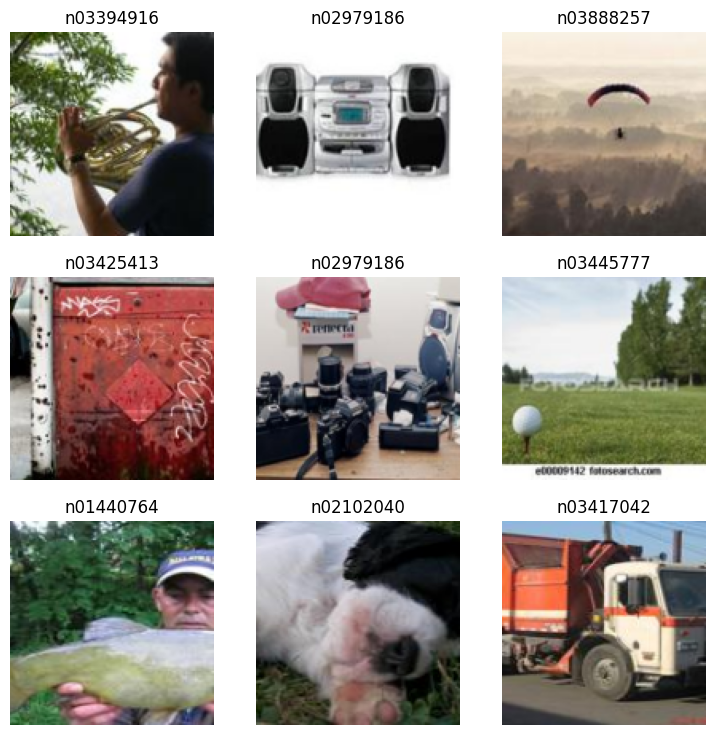

In [8]:
dls.show_batch()

In [9]:
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

In [10]:
def label_func(fname):
  return lbl_dict[parent_label(fname)]

In [11]:
dblock= DataBlock(get_items= get_image_files,
                  get_y= label_func)

In [12]:
dsets= dblock.datasets(path)
dsets.train[0]

(Path('/root/.fastai/data/imagenette2-160/val/n03425413/n03425413_15070.JPEG'),
 'gas pump')

In [13]:
dblock = DataBlock(blocks= (ImageBlock,CategoryBlock),
                   get_items = get_image_files,
                   get_y=label_func)

dsets = dblock.datasets(path)
dsets.train[0]

(PILImage mode=RGB size=160x160, TensorCategory(7))

In [14]:
dsets.vocab

['English springer', 'French horn', 'cassette player', 'chain saw', 'church', 'garbage truck', 'gas pump', 'golf ball', 'parachute', 'tench']

In [15]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = GrandparentSplitter())

dsets = dblock.datasets(path)
dsets.train[0]

(PILImage mode=RGB size=252x160, TensorCategory(7))

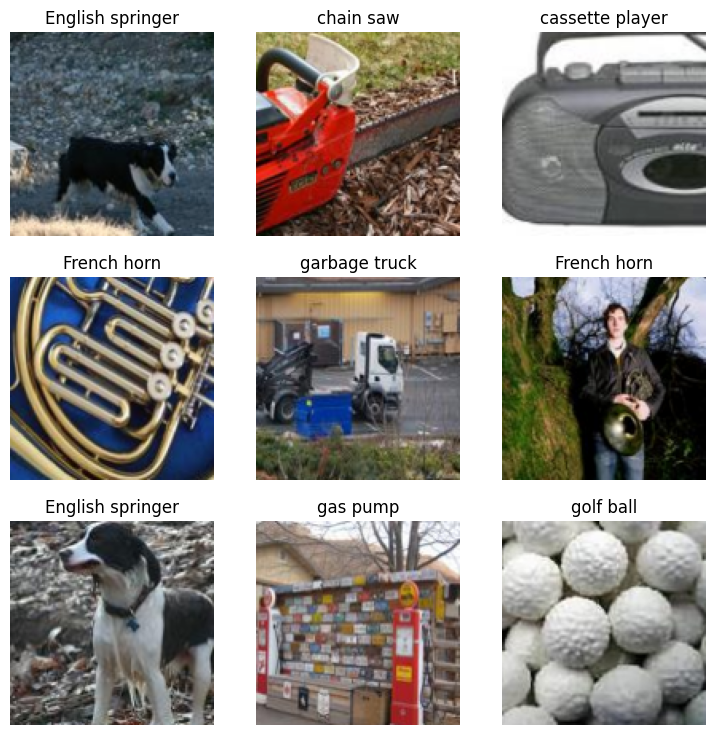

In [16]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = GrandparentSplitter(),
                   item_tfms=RandomResizedCrop(128,min_scale=0.35),
                   batch_tfms=Normalize.from_stats(*imagenet_stats))

dsets = dblock.dataloaders(path)
dsets.show_batch()

# Try pipeline

In [17]:
imagenette = DataBlock(blocks = (ImageBlock, CategoryBlock),
                       get_items = get_image_files,
                       get_y = Pipeline([parent_label, lbl_dict.__getitem__]),
                       splitter = GrandparentSplitter(valid_name='val'),
                       item_tfms = RandomResizedCrop(128, min_scale=0.35),
                       batch_tfms = Normalize.from_stats(*imagenet_stats))

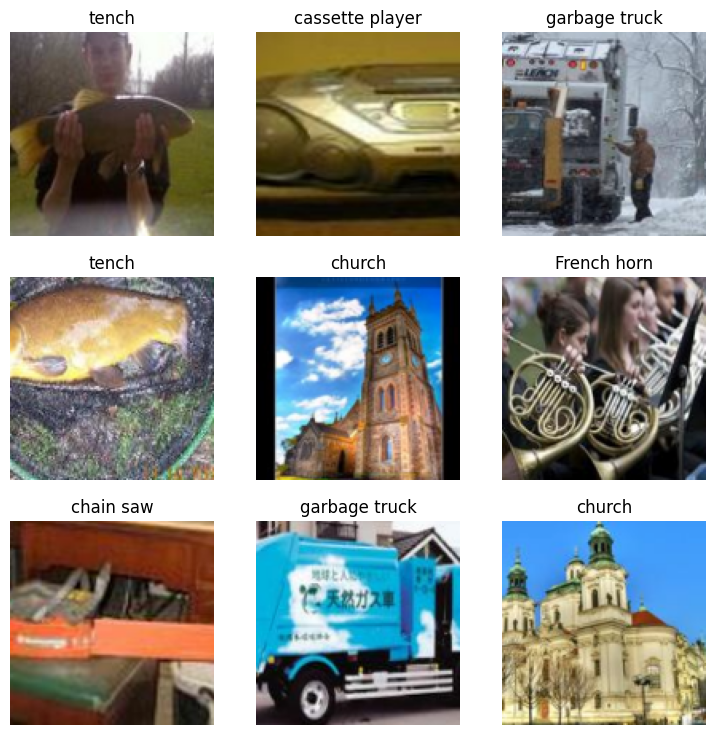

In [18]:
dls= imagenette.dataloaders(path)
dls.show_batch()

In [19]:
#using mid-level-API
source = untar_data(URLs.IMAGENETTE_160)
fnames = get_image_files(source)

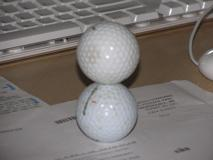

In [20]:
PILImage.create(fnames[0])

In [22]:
lbl_dict[parent_label(fnames[0])]

'golf ball'

In [24]:
tfm= Pipeline([parent_label,lbl_dict.__getitem__,Categorize(vocab= lbl_dict.values())])

In [27]:
tfm(fnames[0])

TensorCategory(7)

In [28]:
splits= GrandparentSplitter(valid_name='val')(fnames)

In [33]:
dsets = Datasets(fnames, [[PILImage.create], [parent_label, lbl_dict.__getitem__, Categorize]], splits=splits)

In [34]:
dsets[0]

(PILImage mode=RGB size=213x160, TensorCategory(7))

<Axes: title={'center': 'golf ball'}>

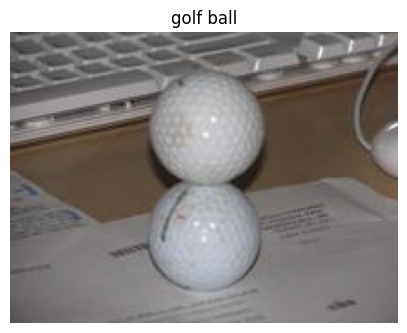

In [35]:
dsets.show(dsets[0])

In [36]:
item_tfms = [ToTensor, RandomResizedCrop(128, min_scale=0.35)]

In [37]:
batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]

In [38]:
dls = dsets.dataloaders(after_item=item_tfms, after_batch=batch_tfms, bs=64, num_workers=8)

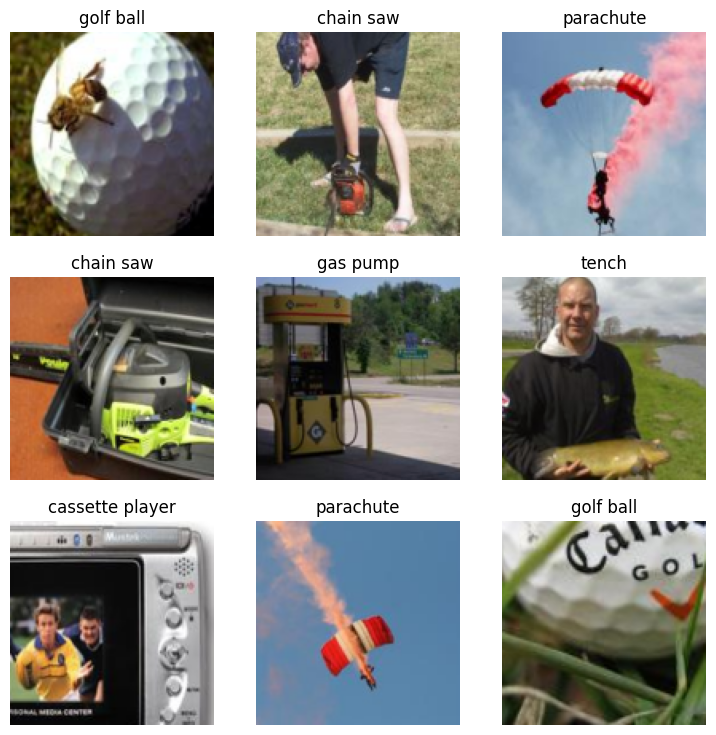

In [39]:
dls.show_batch()

In [40]:
#Training
learn = vision_learner(dls, resnet34, metrics=accuracy, pretrained=False)

In [41]:
learn.fit_one_cycle(5,5e-3)

In [43]:
learn = Learner(dls, xresnet34(n_out=10), metrics=accuracy)

SuggestedLRs(valley=0.0002754228771664202)

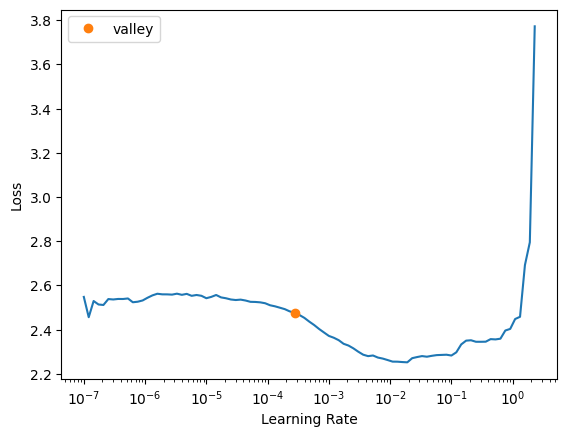

In [44]:
learn.lr_find()

In [45]:
learn.fit_one_cycle(5, 1e-3)

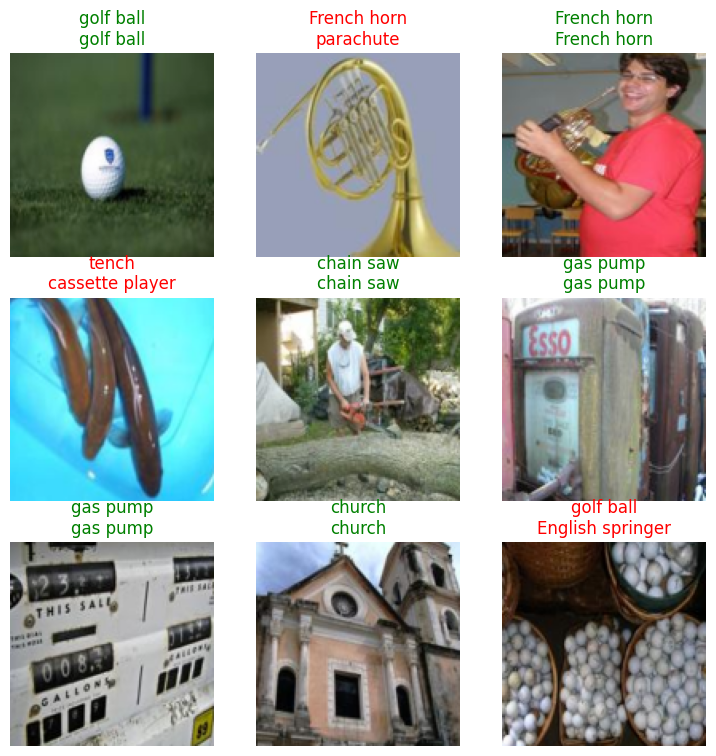

In [46]:
learn.show_results()

In [47]:
learn = Learner(dls, xresnet34(n_out=10), loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)

In [48]:
learn.fit_one_cycle(5, 1e-3)

In [49]:
learn.predict(fnames[0])

('golf ball',
 tensor(7),
 tensor([0.1660, 0.0080, 0.1005, 0.0674, 0.0096, 0.0161, 0.0282, 0.5130, 0.0624,
         0.0287]))

In [50]:
pred,_,_=learn.predict(fnames[0])
pred

'golf ball'

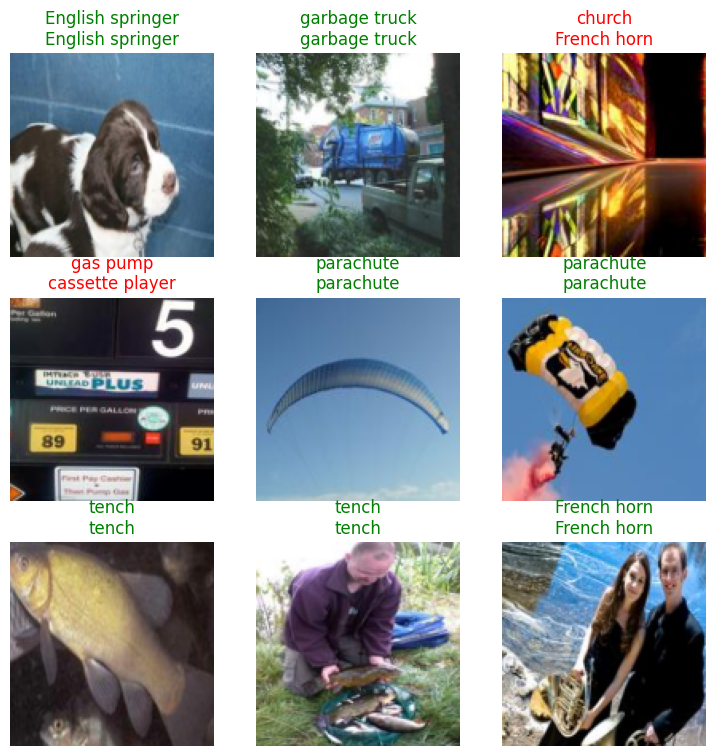

In [51]:
learn.show_results()

In [52]:
pytorch_adamw = partial(OptimWrapper, opt=torch.optim.AdamW)

In [53]:
learn = Learner(dls, xresnet18(), lr=1e-2, metrics=accuracy,
                loss_func=LabelSmoothingCrossEntropy(),
                opt_func=partial(pytorch_adamw, weight_decay=0.01, eps=1e-3))

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(valley=0.00363078061491251)

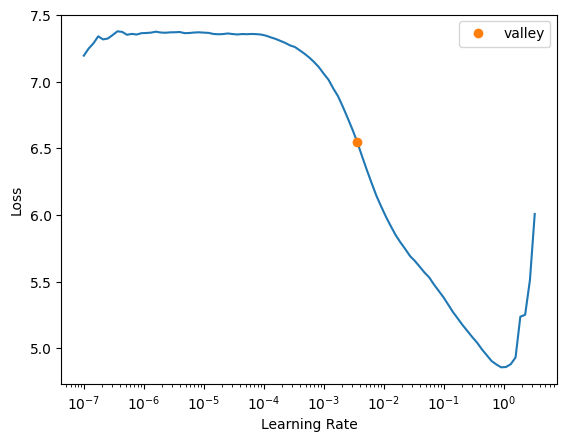

In [54]:
learn.lr_find()

In [55]:
learn.fit_one_cycle(5, 5e-3)

In [56]:
learn = Learner(dls, xresnet18(), lr=1e-2, metrics=accuracy,
                loss_func=LabelSmoothingCrossEntropy(), cbs=MixUp(),
                opt_func=partial(pytorch_adamw, weight_decay=0.01, eps=1e-3))

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(valley=0.002511886414140463)

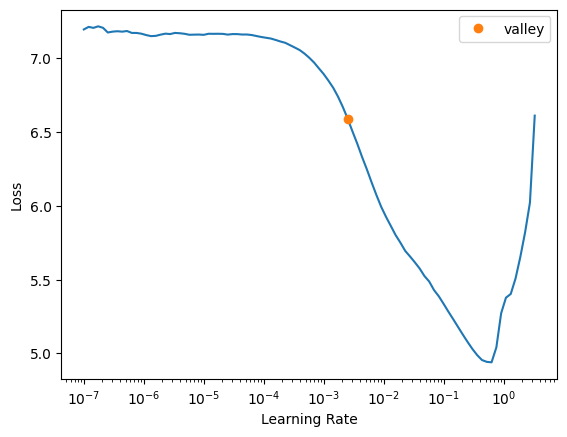

In [57]:
learn.lr_find()

In [58]:
learn.fit_one_cycle(10, 5e-3)

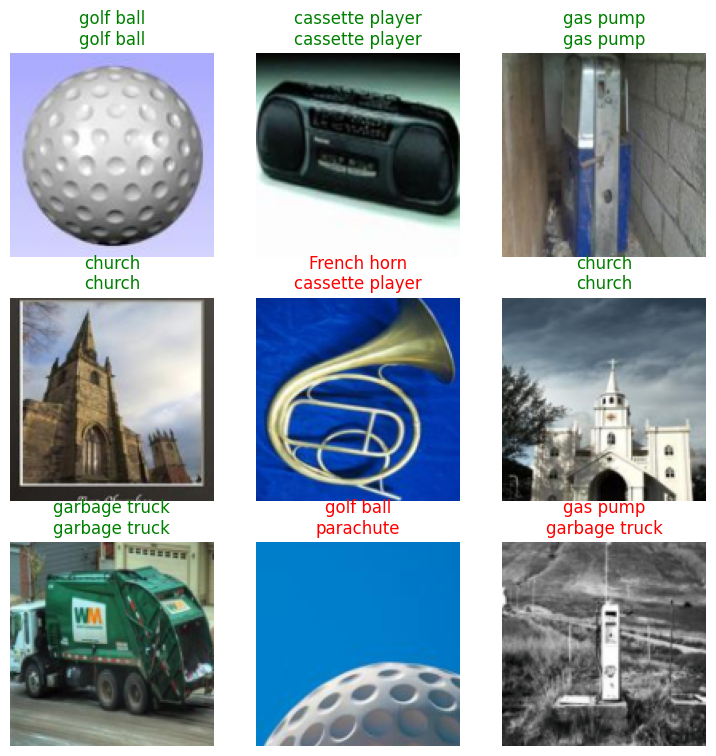

In [63]:
learn.show_results()